In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time
import copy
import matplotlib.pyplot as plt

Resize and Normalize

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.225, 0.225]),
])

In [ ]:
train_ds = OxfordIIITPet(root='.', split='trainval', transform=transform, download=True)
test_ds = OxfordIIITPet(root='.', split='test', transform=transform, download=True)


100%|██████████| 791918971/791918971 [00:37<00:00, 21021642.53it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 7779097.33it/s] 


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


ResNet-50 (1000 outputs) & ResNet-50 without the last layer (2048 outputs)

In [ ]:
resnet50_model = resnet50(weights=True)
resnet50_feature_extract = torch.nn.Sequential(*(list(resnet50_model.children())[:-1]))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 83.9MB/s]


In [ ]:
# Extract features using ResNet50
def extract_features(model, dataloader):
    features = []
    labels = []

    with torch.no_grad():       # No need to train, just evaluating
        for image, target in dataloader:
            image = image.cuda()
            feature = model(image)
            features.append(feature.squeeze().cpu().numpy())
            labels.extend(target.numpy())

    features = np.array(features)
    return features, labels

In [ ]:
BATCH_SIZE = 64

In [ ]:
train_dataloader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True)    # Shuffle train dataloader
test_dataloader = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle=False)

In [ ]:
# !nvidia-smi
torch.cuda.is_available()

True

Feature Extraction

In [ ]:
model = resnet50_feature_extract

model.eval()
model = model.cuda()

train_features, train_labels = extract_features(model, train_dataloader)
test_features, test_labels = extract_features(model, test_dataloader)

<ipython-input-55-32427f60788f>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(features)


In [ ]:
# Remove batch dim
train_features_flat = np.concatenate(train_features, axis=0)
test_features_flat = np.concatenate(test_features, axis=0)

In [ ]:
train_features_flat.shape

(3680, 2048)

## **(A) k-NN Classifier with k = 1**

---





In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(train_features_flat, train_labels)

predictions = knn_classifier.predict(test_features_flat)
accuracy = accuracy_score(test_labels, predictions)

In [ ]:
accuracy

0.8765331152902698

## **(B) Training the last FC layer keeping Feature Extractor frozen**

---



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = resnet50(weights=True)

for param in model.parameters():
  param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.fc = torch.nn.Linear(2048, 37)      # Replace the last FC layer
torch.nn.init.xavier_uniform_(model.fc.weight)

model = model.to(device)

In [ ]:
# Train function
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0

    for (input, labels) in train_dataloader:
      # print(input.shape, labels.shape)
      data, target = input.to(device), labels.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      train_running_loss += loss.item()
      _, preds = torch.max(output.data, dim = 1)
      train_running_correct += (preds == target).sum().item()
      loss.backward()
      optimizer.step()

    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')

    return train_loss, train_accuracy

In [ ]:
# Evaluation Function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
      for (input, labels) in test_dataloader:
          data, target = input.to(device), labels.to(device)
          output = model(data)
          loss = criterion(output, target)
          val_running_loss += loss.item()
          _, preds = torch.max(output.data, dim = 1)
          val_running_correct += (preds == target).sum().item()

    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.2f}')

    return val_loss, val_accuracy

In [ ]:
# Loss function
criterion = torch.nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9, weight_decay=1e-4)

In [ ]:
num_epochs = 10

In [ ]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()

# Run training and testing
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}')
    train_epoch_loss, train_epoch_accuracy = fit(model, train_dataloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, test_dataloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()
print((end-start)/60, 'minutes')

Epoch 1
Train Loss: 0.0518, Train Acc: 16.63
Validation Loss: 0.0416, Validation Acc: 45.60
Epoch 2
Train Loss: 0.0342, Train Acc: 62.61
Validation Loss: 0.0279, Validation Acc: 74.08
Epoch 3
Train Loss: 0.0238, Train Acc: 78.51
Validation Loss: 0.0203, Validation Acc: 81.60
Epoch 4
Train Loss: 0.0178, Train Acc: 84.59
Validation Loss: 0.0162, Validation Acc: 84.38
Epoch 5
Train Loss: 0.0145, Train Acc: 87.72
Validation Loss: 0.0135, Validation Acc: 85.94
Epoch 6
Train Loss: 0.0122, Train Acc: 88.40
Validation Loss: 0.0120, Validation Acc: 87.19
Epoch 7
Train Loss: 0.0108, Train Acc: 89.70
Validation Loss: 0.0108, Validation Acc: 87.65
Epoch 8
Train Loss: 0.0096, Train Acc: 90.73
Validation Loss: 0.0099, Validation Acc: 88.83
Epoch 9
Train Loss: 0.0088, Train Acc: 91.20
Validation Loss: 0.0092, Validation Acc: 88.44
Epoch 10
Train Loss: 0.0081, Train Acc: 91.74
Validation Loss: 0.0087, Validation Acc: 88.93
10.33870423634847 minutes


In [ ]:
resnet_frozen_classifier = copy.deepcopy(model)

In [ ]:
def draw_acc_loss_graphs(train_loss, val_loss, train_accuracy, val_accuracy, num_epochs):
  epochs = np.array([i for i in range(1,num_epochs + 1)]).reshape(num_epochs,1)

  plt.figure(figsize=(12, 5))

  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.xticks(np.arange(1, num_epoches + 1, step=1))
  plt.xlabel('Epoch Number')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, train_accuracy, label='Training Accuracy')
  plt.plot(epochs, val_accuracy, label='Validation Accuracy')
  plt.xticks(np.arange(1, num_epoches + 1, step=1))
  plt.xlabel('Epoch Number')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.ylim(0, 100)

  plt.show()

In [ ]:
draw_acc_loss_graphs(train_loss, val_loss, train_accuracy, val_accuracy, num_epochs)

NameError: ignored

In [ ]:
last_layer_params = model.fc.parameters()
for param in last_layer_params:
  print(param[1])

tensor([-0.0376,  0.0123,  0.0221,  ...,  0.0325, -0.0042,  0.0153],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0121, device='cuda:0', grad_fn=<SelectBackward0>)


## **(C) Fine-Tuning the whole model**

---



In [ ]:
for param in model.parameters():
  param.requires_grad = True

In [ ]:
train_loss_ft , train_accuracy_ft = [], []
val_loss_ft , val_accuracy_ft = [], []
start = time.time()

# Run training and testing
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}')
    train_epoch_loss, train_epoch_accuracy = fit(model, train_dataloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, test_dataloader)
    train_loss_ft.append(train_epoch_loss)
    train_accuracy_ft.append(train_epoch_accuracy)
    val_loss_ft.append(val_epoch_loss)
    val_accuracy_ft.append(val_epoch_accuracy)

end = time.time()
print((end-start)/60, 'minutes')

Epoch 1
Train Loss: 0.0061, Train Acc: 93.21
Validation Loss: 0.0053, Validation Acc: 91.58
Epoch 2
Train Loss: 0.0032, Train Acc: 96.71
Validation Loss: 0.0047, Validation Acc: 92.12
Epoch 3
Train Loss: 0.0020, Train Acc: 98.42
Validation Loss: 0.0042, Validation Acc: 92.94
Epoch 4
Train Loss: 0.0014, Train Acc: 99.38
Validation Loss: 0.0041, Validation Acc: 92.86
Epoch 5
Train Loss: 0.0010, Train Acc: 99.70
Validation Loss: 0.0040, Validation Acc: 92.64
Epoch 6
Train Loss: 0.0008, Train Acc: 99.73
Validation Loss: 0.0039, Validation Acc: 92.86
Epoch 7
Train Loss: 0.0006, Train Acc: 99.92
Validation Loss: 0.0039, Validation Acc: 92.78
Epoch 8
Train Loss: 0.0006, Train Acc: 100.00
Validation Loss: 0.0039, Validation Acc: 92.91
Epoch 9
Train Loss: 0.0004, Train Acc: 100.00
Validation Loss: 0.0039, Validation Acc: 93.08
Epoch 10
Train Loss: 0.0004, Train Acc: 99.97
Validation Loss: 0.0038, Validation Acc: 92.86
11.17098061243693 minutes


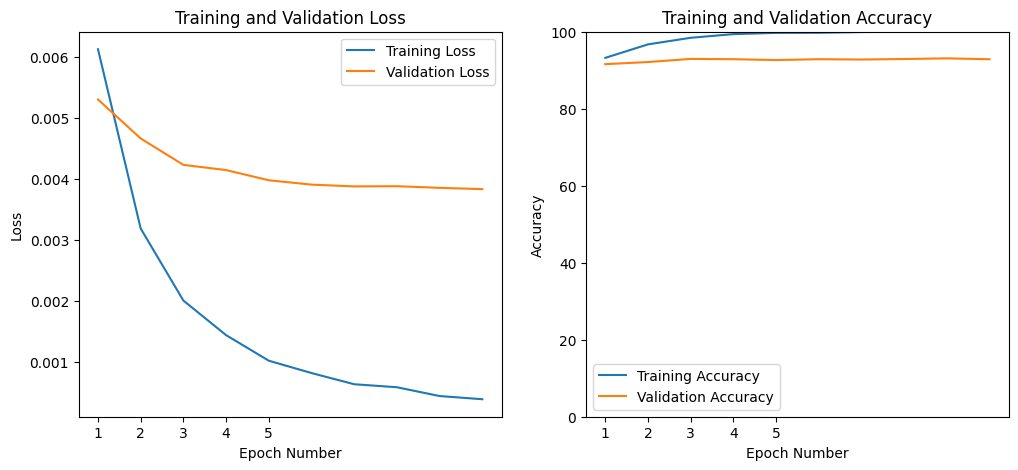

In [ ]:
draw_acc_loss_graphs(train_loss_ft, val_loss_ft, train_accuracy_ft, val_accuracy_ft, num_epochs)